# Климат Европы: среднемесячная температура по странам

Источник: https://www.ecad.eu - отсюда берем данные с метеостанций по странам
Качаем при помощи этого: https://www.ecad.eu/dailydata/customquery.php - нужны данные по средней температуре (там идет по дням)

Скаченные данные:
  - Германия (по станции BERLIN-DAHLEM, STAID = 41)
  - Франция (по станции ORLY, STAID = 11249)
  - Испания (по станции MADRID-RETIRO, STAID = 230)
  - Австрия (по станции WIEN-HOWE WARTE, STAID = 16)
  
нужны файлы TGxxxxxx - среднедневные температуры. Скачиваются файлы zip с кучей показателей - вручную распаковываем файлы TG в корень этого блокнота

**Температура приводится в десятых долях градуса (0.1C)**

In [1]:
import pandas as pd
import datetime as dt
import requests
from bs4 import BeautifulSoup as BS
import re
import calendar
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from io import StringIO

%matplotlib inline

**Ниже - функции для графиков**

In [2]:
lstSeas = ['зима', 'весна', 'лето', 'осень']
dctSeas = dict(zip(range(1,5), lstSeas ))

lstMonthNames = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек',]
dctMNums = dict(zip(lstMonthNames, range(1, 13)))
dctMonths = dict(zip(range(1, 13), lstMonthNames))

def mark_season(x):
    if x.month in [1, 2, 12]:
        return 1
    elif x.month in [3, 4, 5]:
        return 2
    elif x.month in [6, 7, 8]:
        return 3
    else:
        return 4

def plot_temp1(pdf, legends_dict=dctSeas, colors=['teal', 'limegreen', 'orange', 'indianred'], title=None):
    
    cnt = len(pdf.columns)
    widths = [8, 2]
    axs = list()
    
    fig2 = plt.figure(constrained_layout=True, figsize=(17, 3*cnt))
    spec2 = gridspec.GridSpec(ncols=2, nrows=cnt, figure=fig2, width_ratios=widths)
    
    if title:
        fig2.suptitle(title, fontsize=14)
    
    for i in pdf.columns:
        if i==1:
            ax1 = fig2.add_subplot(spec2[i-1, 0])
            ax2 = fig2.add_subplot(spec2[i-1, 1], sharey=ax1)
        else:
            ax1 = fig2.add_subplot(spec2[i-1, 0], sharex=axs[0][0])
            ax2 = fig2.add_subplot(spec2[i-1, 1], sharey=ax1, sharex=axs[0][1])  
            
        pdf[i].plot.line(ax=ax1, grid=True, rot=90, xticks=pdf.index, xlabel='', color=colors[i-1])
        _p = pdf[[i]].copy()
        _p['до потепления'] = _p.loc[:climate_change, i]
        _p['потепление'] = _p.loc[climate_change:, i]
        _p.boxplot(column=['до потепления', 'потепление'], ax=ax2)
        
        ax1.legend(labels = [legends_dict[i],], loc=2)
        y1 = np.mean(pdf.loc[:climate_change, i])
        y2 = np.mean(pdf.loc[climate_change:, i])
        ax1.hlines(y=y1, xmin=pdf.index.min(), xmax=climate_change, colors=['k'], linestyles='dashed', lw=0.7)
        ax1.hlines(y=y2, xmin=climate_change, xmax=pdf.index.max(), colors=['k'], linestyles='dashed', lw=0.7)

        axs.append([ax1, ax2])
        
#     plt.tight_layout()
    return axs

def plot_months(pdf, country=''):

    _ma = pdf.reset_index()
    _ma['month'] = _ma['date'].dt.month
    _ma['year'] = _ma['date'].dt.year
    _ma = _ma[['year', 'month', 'tempC']].set_index(['year', 'month']).unstack(level=-1)
    _ma.columns = [c[1] for c in _ma.columns]

    plot_temp1(_ma, legends_dict=dctMonths, title=f'{country} - температура по месяцам',
               colors=['teal', 'cadetblue', 
                       'seagreen', 'springgreen', 'green', 
                       'forestgreen', 'darkorange', 'orange',
                       'goldenrod', 'indianred', 'sienna', 
                       'darkslategrey'
                      ]);

def plot_seasons(pdf, country=''):
    pdfSeason = pdf.copy()    

    pdfSeason['season'] = pdfSeason.index.map(mark_season)
    pdfSeason['syear'] = pdfSeason.index.year
    pdfSeason.loc[pdfSeason.index.month==12, 'syear']+=1

    pdfSeason = pdfSeason.groupby(by=['syear', 'season'])['tempC'].mean().unstack().reset_index()[['syear', 1, 2, 3, 4]].set_index('syear')
    pdfSeason.columns=[1, 2, 3, 4]

    plot_temp1(pdfSeason, title=f'{country}: температура по сезонам');    
    
def read_csv(strFileName):
    with open(strFileName, 'r') as fl:
        _t = fl.read()
        _pos = _t.find('SOUID,')
    pdf = pd.read_csv(StringIO(_t[_pos:]), sep=',')
    pdf.columns = ['id', 'date', 'tempC', 'stat']
    pdf['date'] = pd.to_datetime(pdf['date'], format='%Y%m%d')
    return pdf[['date', 'tempC', 'stat']]

climate_change = 2000

## Германия (Berlin-Dahlen, 41, файл TG_STAID000041.txt)

In [3]:
strFileGr = 'TG_STAID000041.txt'
pdfG = read_csv(strFileGr)
pdfG

,date,tempC,stat
0,1876-01-01,22,0
1,1876-01-02,25,0
2,1876-01-03,3,0
3,1876-01-04,-58,0
4,1876-01-05,-98,0
...,...,...,...
53229,2021-09-26,180,0
53230,2021-09-27,169,0
53231,2021-09-28,149,0
53232,2021-09-29,134,0


### Проверяем: статус <> 0 значит что данные недостоверные

In [4]:
pdfG[pdfG['stat']!=0]

,date,tempC,stat
19398,1929-02-10,-226,1
25316,1945-04-25,-9999,9
25317,1945-04-26,-9999,9
25318,1945-04-27,-9999,9
25319,1945-04-28,-9999,9
...,...,...,...
25506,1945-11-01,-9999,9
25507,1945-11-02,-9999,9
25508,1945-11-03,-9999,9
25509,1945-11-04,-9999,9


In [5]:
pdfG = pdfG[pdfG['date'].dt.year > 1949]
pdfG = pdfG.set_index('date')
pdfGTemp = pdfG.groupby(pd.Grouper(freq='MS'))['tempC'].mean() * 0.1
pdfGTemp = pd.DataFrame(pdfGTemp)
pdfGTemp

,tempC
date,
1950-01-01,-1.383871
1950-02-01,3.010714
1950-03-01,5.374194
1950-04-01,7.990000
1950-05-01,15.393548
...,...
2021-05-01,12.003226
2021-06-01,20.743333
2021-07-01,20.312903


### Графики

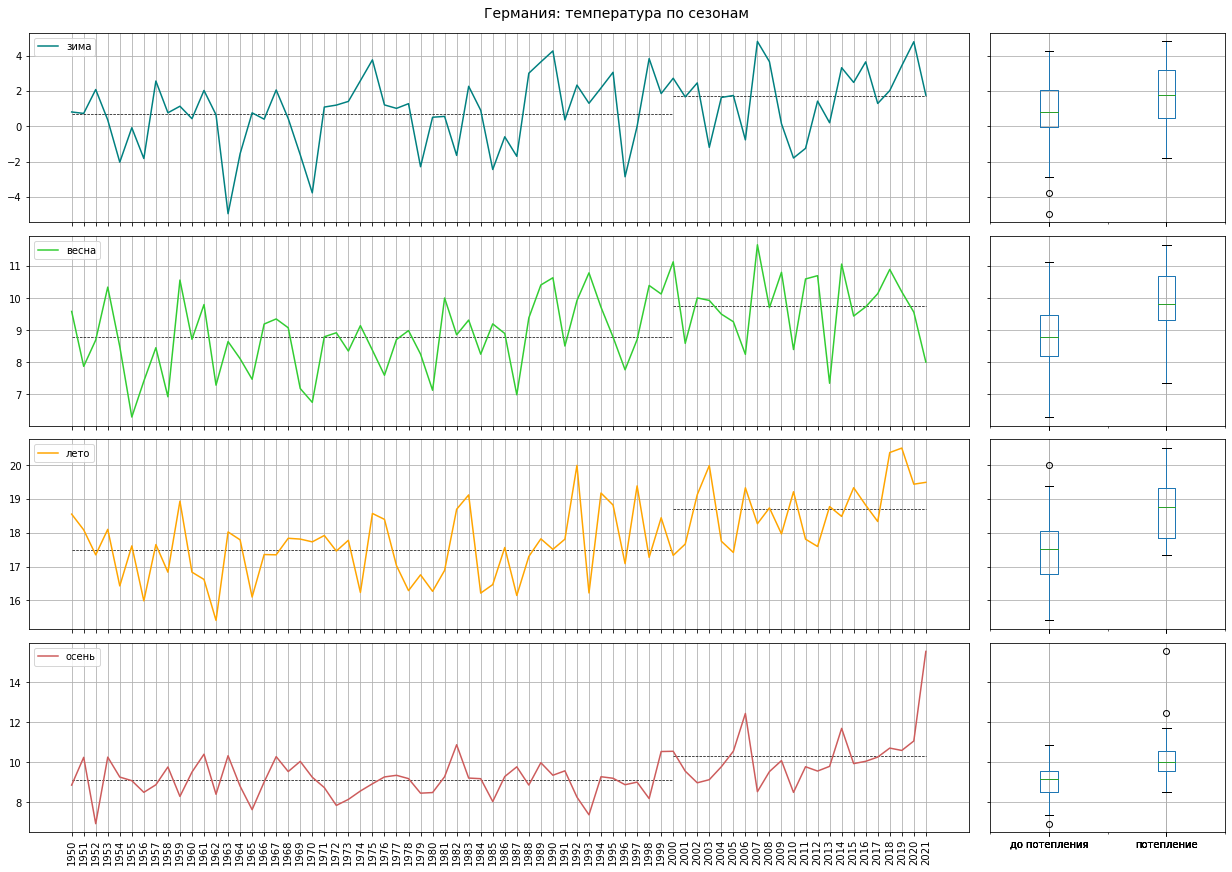

In [6]:
plot_seasons(pdfGTemp, country='Германия')

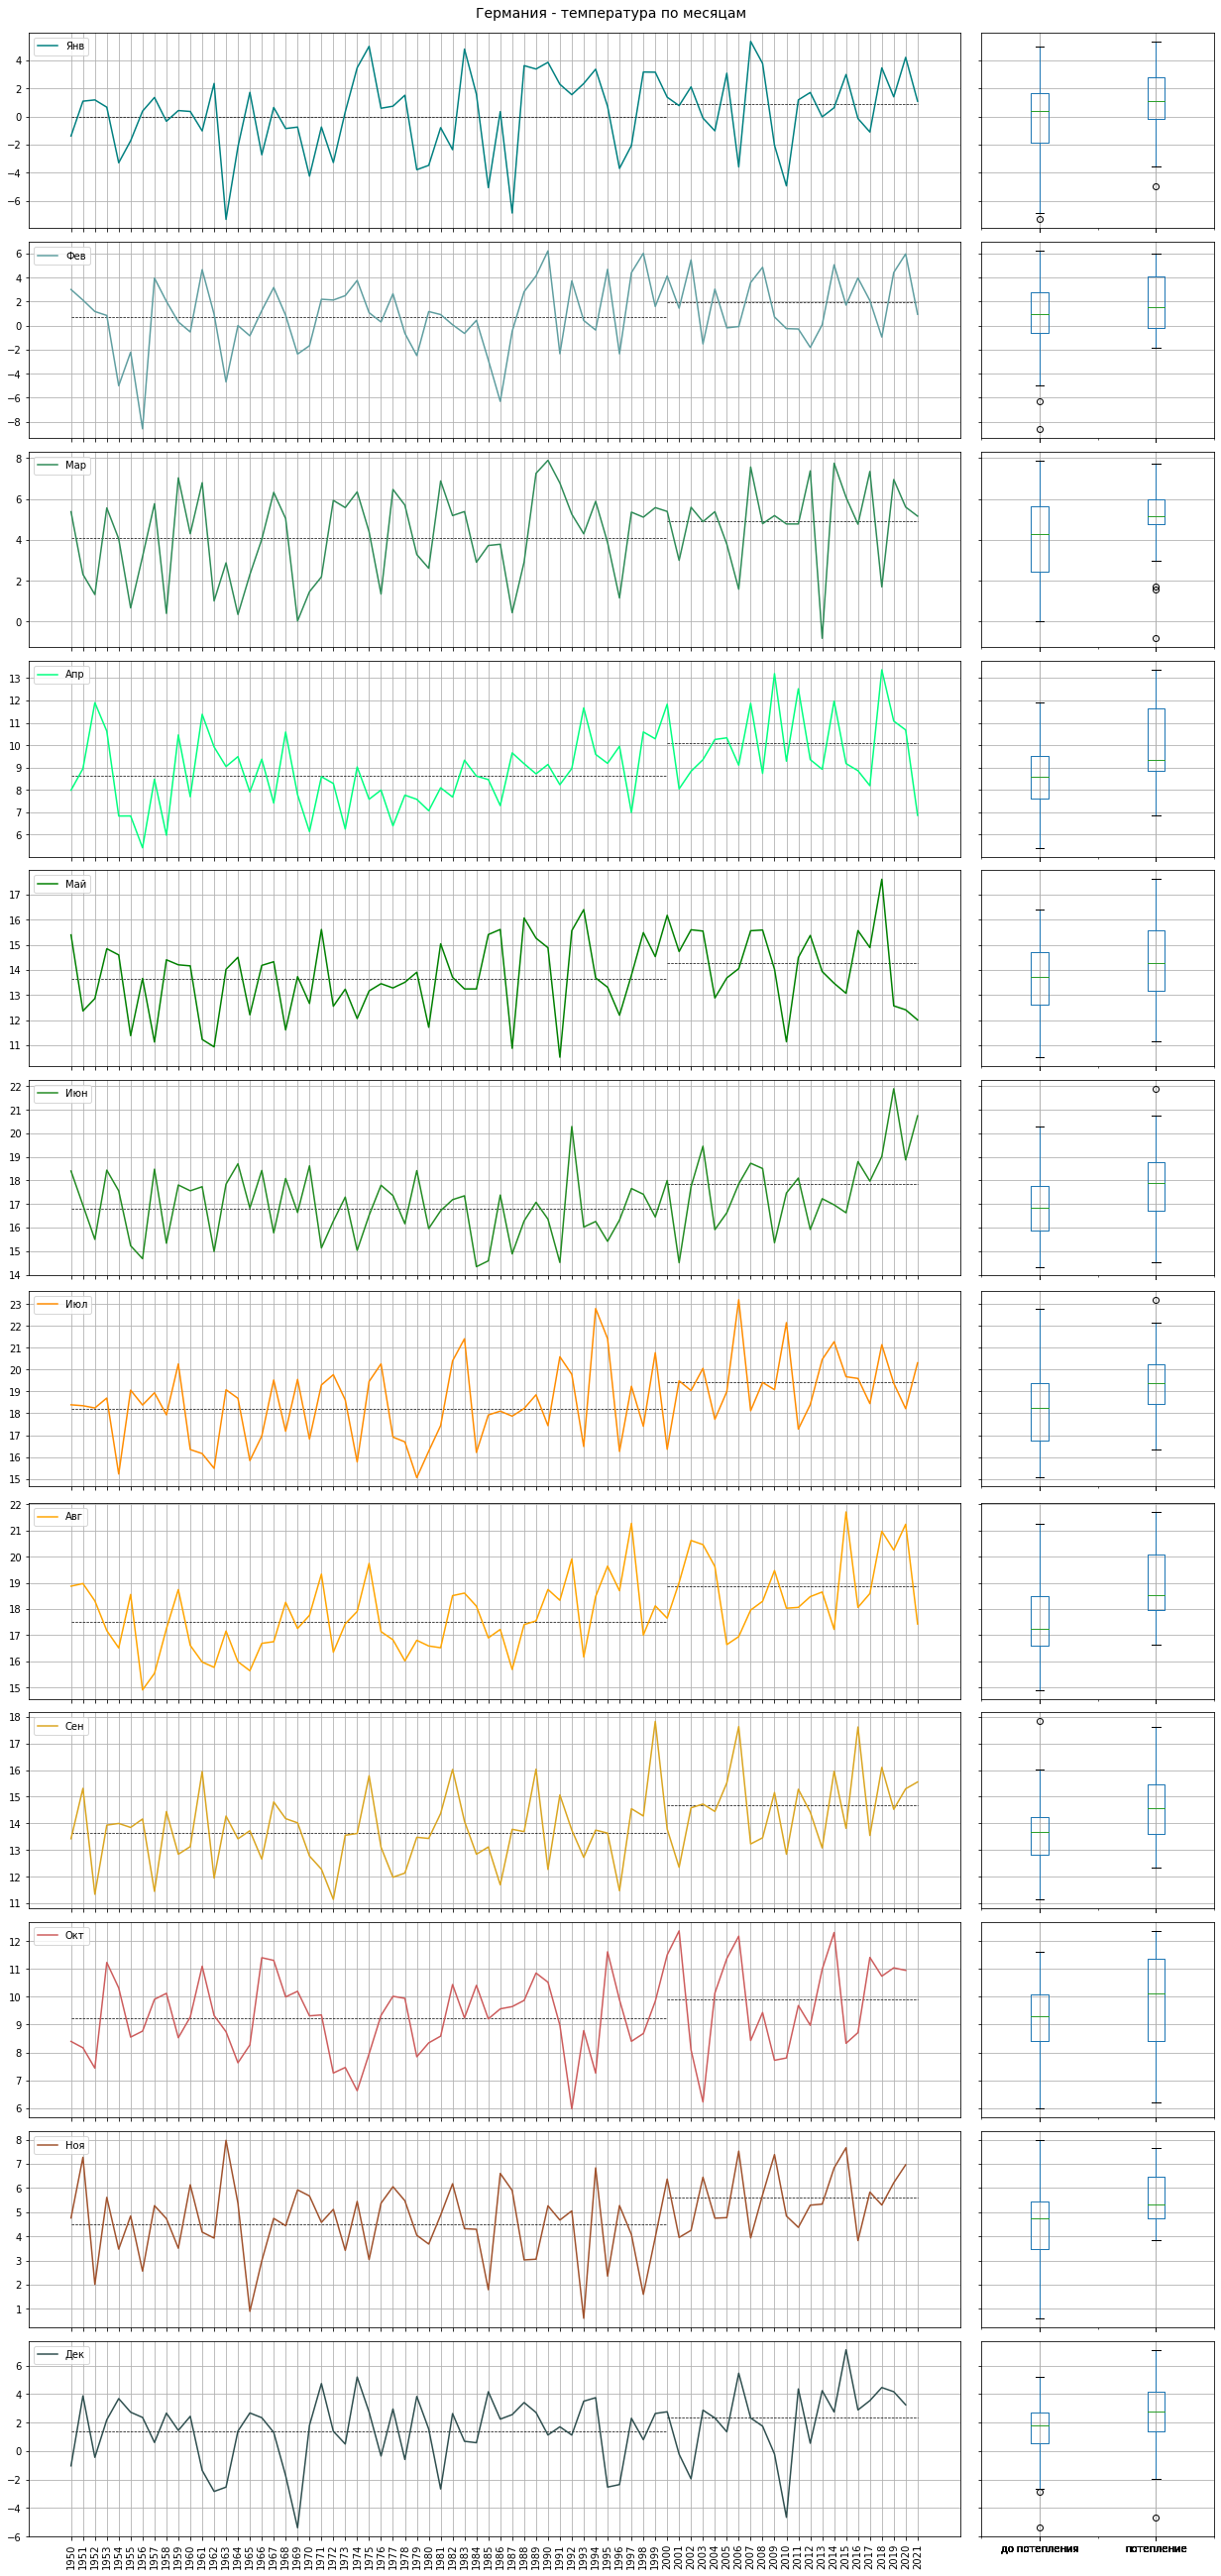

In [7]:
plot_months(pdfGTemp, country='Германия')

## Франция (ORLY, 11249, файл TG_STAID011249.txt)



In [8]:
strFileFr = 'TG_STAID011249.txt'
pdfF = read_csv(strFileFr)
pdfF

,date,tempC,stat
0,1921-03-01,50,0
1,1921-03-02,46,0
2,1921-03-03,46,0
3,1921-03-04,31,0
4,1921-03-05,95,0
...,...,...,...
36734,2021-09-26,182,0
36735,2021-09-27,164,0
36736,2021-09-28,145,0
36737,2021-09-29,146,0


### Проверяем: статус <> 0 значит что данные недостоверные

In [9]:
pdfF[pdfF['stat']!=0]

,date,tempC,stat
176,1921-08-24,-9999,9
177,1921-08-25,-9999,9
214,1921-10-01,-9999,9
307,1922-01-02,-9999,9
338,1922-02-02,-9999,9
...,...,...,...
9798,1947-12-28,-9999,9
9799,1947-12-29,-9999,9
9800,1947-12-30,-9999,9
9801,1947-12-31,-9999,9


In [10]:
pdfF = pdfF[pdfF['date'].dt.year > 1949]
pdfF = pdfF.set_index('date')

pdfFTemp = pdfF.groupby(pd.Grouper(freq='MS'))['tempC'].mean() * 0.1
pdfFTemp = pd.DataFrame(pdfFTemp)
pdfFTemp

,tempC
date,
1950-01-01,2.006452
1950-02-01,6.678571
1950-03-01,7.600000
1950-04-01,8.800000
1950-05-01,14.354839
...,...
2021-05-01,13.267742
2021-06-01,20.003333
2021-07-01,20.235484


### Графики

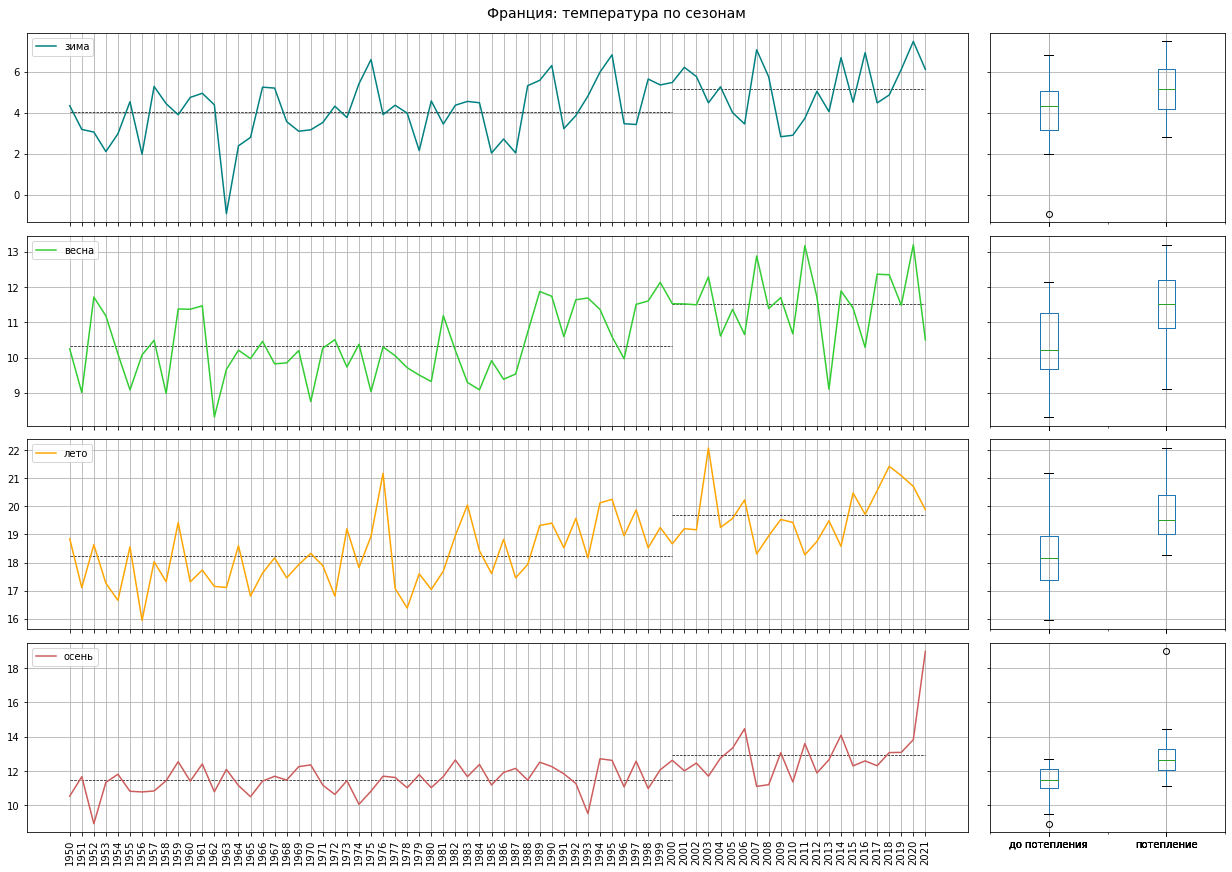

In [11]:
plot_seasons(pdfFTemp, country='Франция')

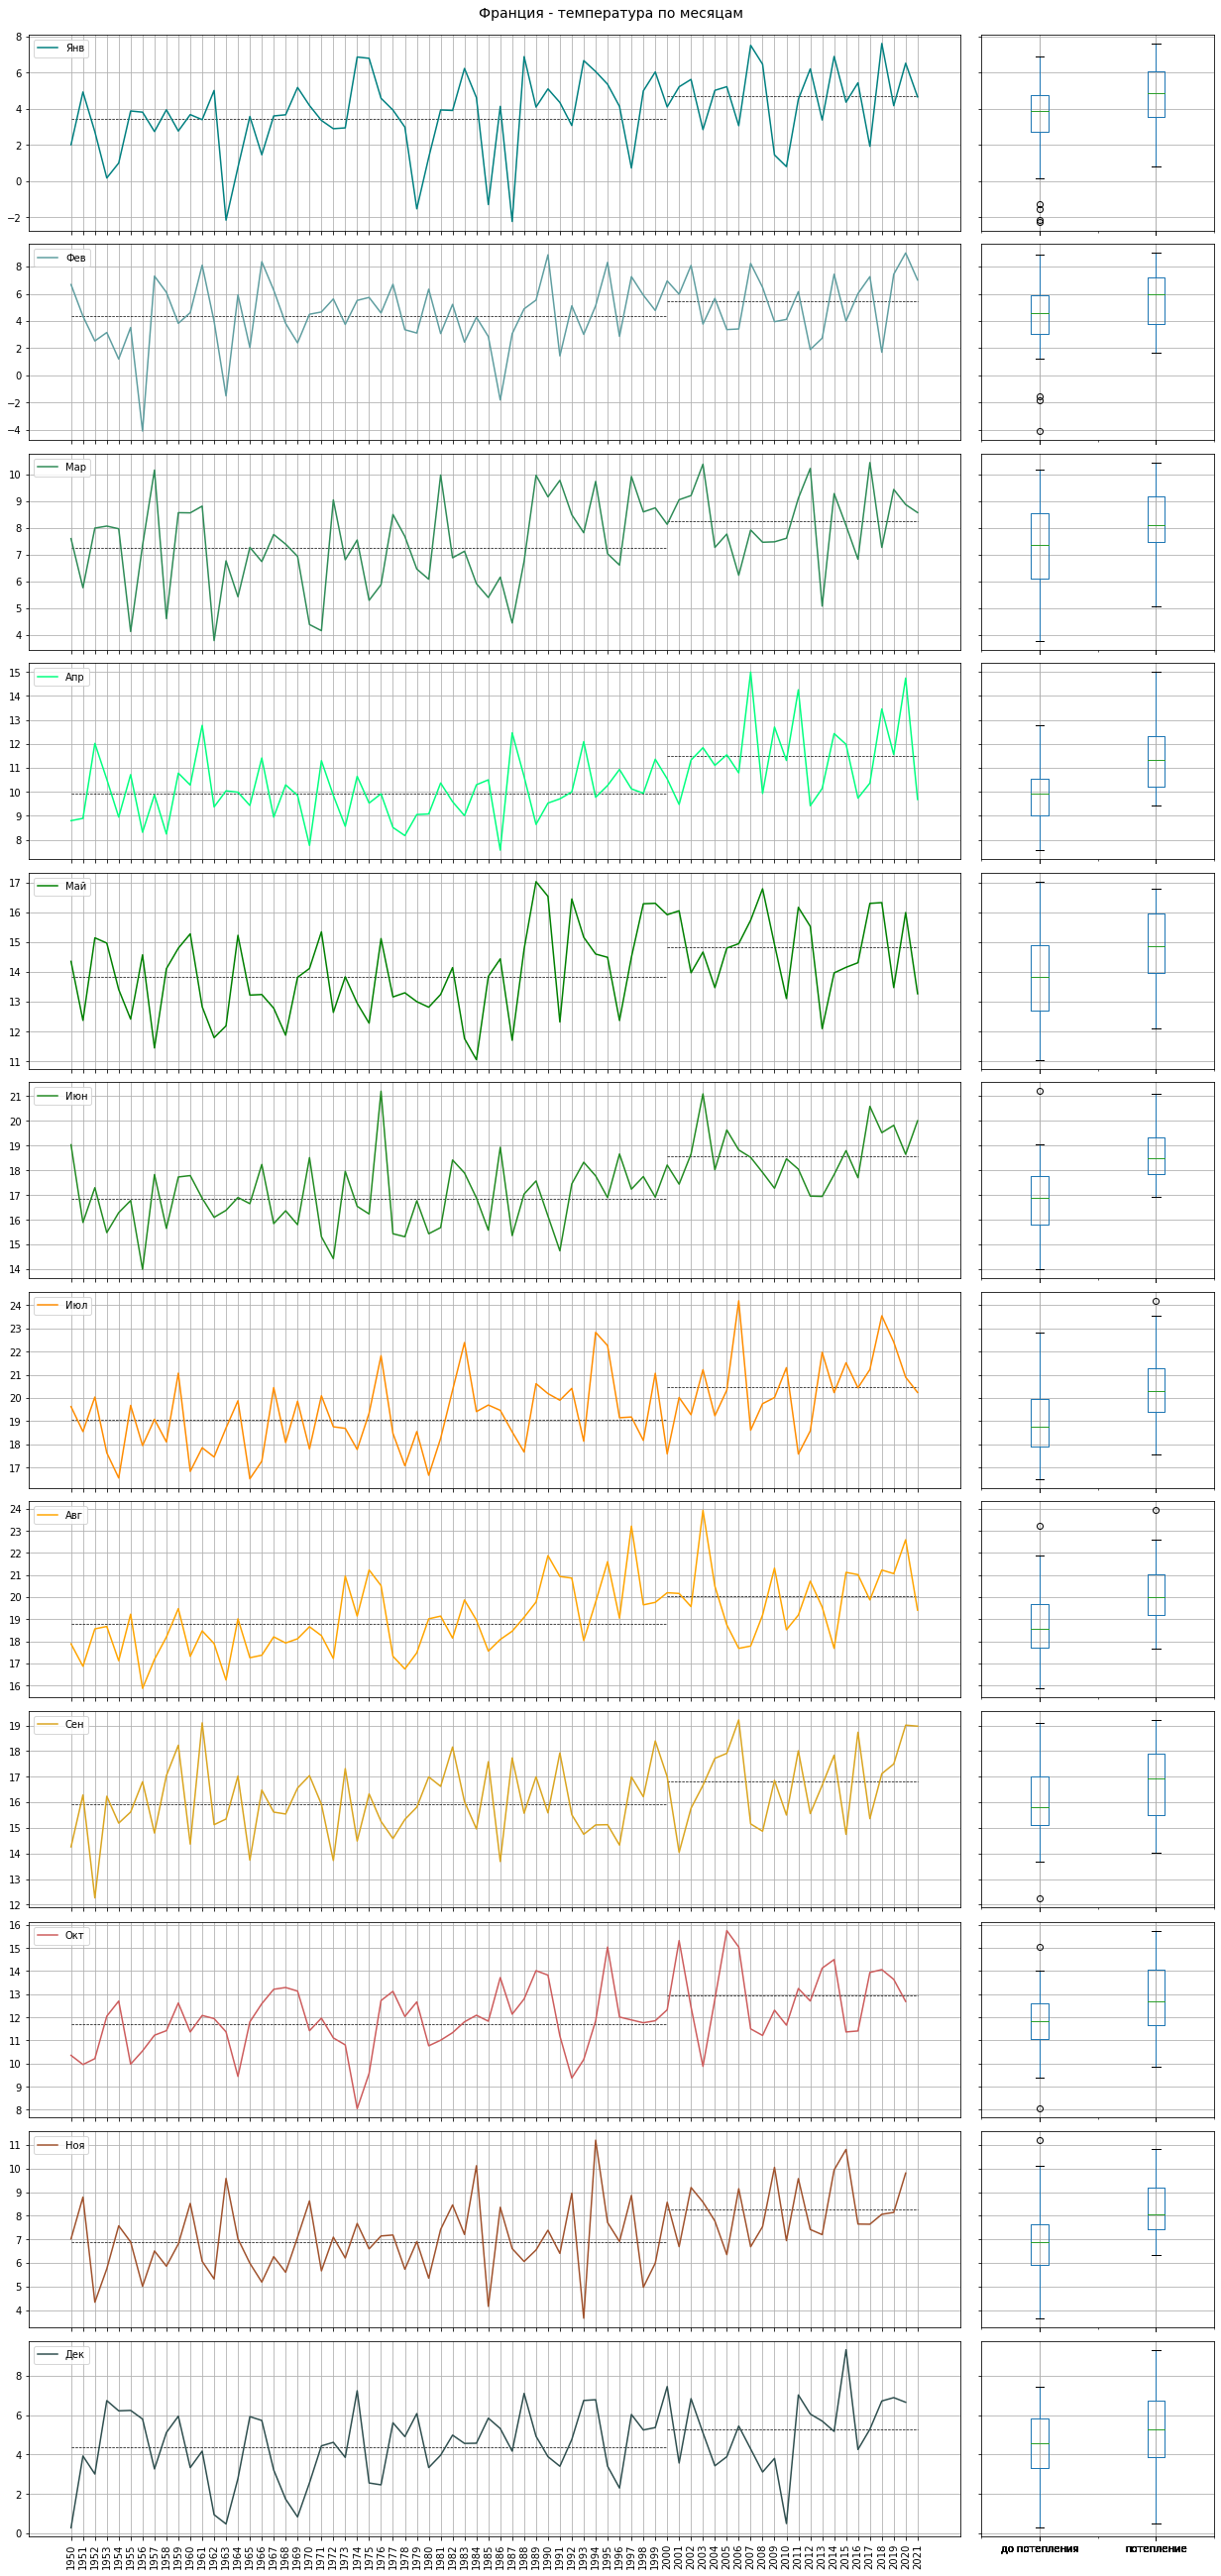

In [12]:
plot_months(pdfFTemp, country='Франция')

## Австрия (WIEN-HOWE WARTE, 16, файл TG_STAID000016.txt)

In [13]:
strFileA = 'TG_STAID000016.txt'

pdfA = read_csv(strFileA)
pdfA

,date,tempC,stat
0,1901-01-01,-83,0
1,1901-01-02,-112,0
2,1901-01-03,-107,0
3,1901-01-04,-106,0
4,1901-01-05,-124,0
...,...,...,...
44098,2021-09-26,175,0
44099,2021-09-27,161,0
44100,2021-09-28,200,0
44101,2021-09-29,153,0


### Проверяем: статус <> 0 значит что данные недостоверные

In [14]:
pdfA[pdfA['stat']!=0]

,date,tempC,stat
366,1902-01-02,34,1
729,1902-12-31,31,1
1356,1904-09-18,120,1
1783,1905-11-19,58,1
1876,1906-02-20,14,1
4005,1911-12-20,24,1
4421,1913-02-08,15,1
4795,1914-02-17,-21,1
4814,1914-03-08,67,1
5091,1914-12-10,37,1


In [15]:
pdfA = pdfA[(pdfA['date'].dt.year > 1949) & (pdfA['stat']==0) ]
pdfA = pdfA.set_index('date')
# pdfA
pdfATemp = pdfA.groupby(pd.Grouper(freq='MS'))['tempC'].mean() * 0.1
pdfATemp = pd.DataFrame(pdfATemp)
pdfATemp

,tempC
date,
1950-01-01,-2.787097
1950-02-01,2.075000
1950-03-01,7.116129
1950-04-01,10.366667
1950-05-01,16.470968
...,...
2021-05-01,14.148387
2021-06-01,22.313333
2021-07-01,23.006452


### Графики

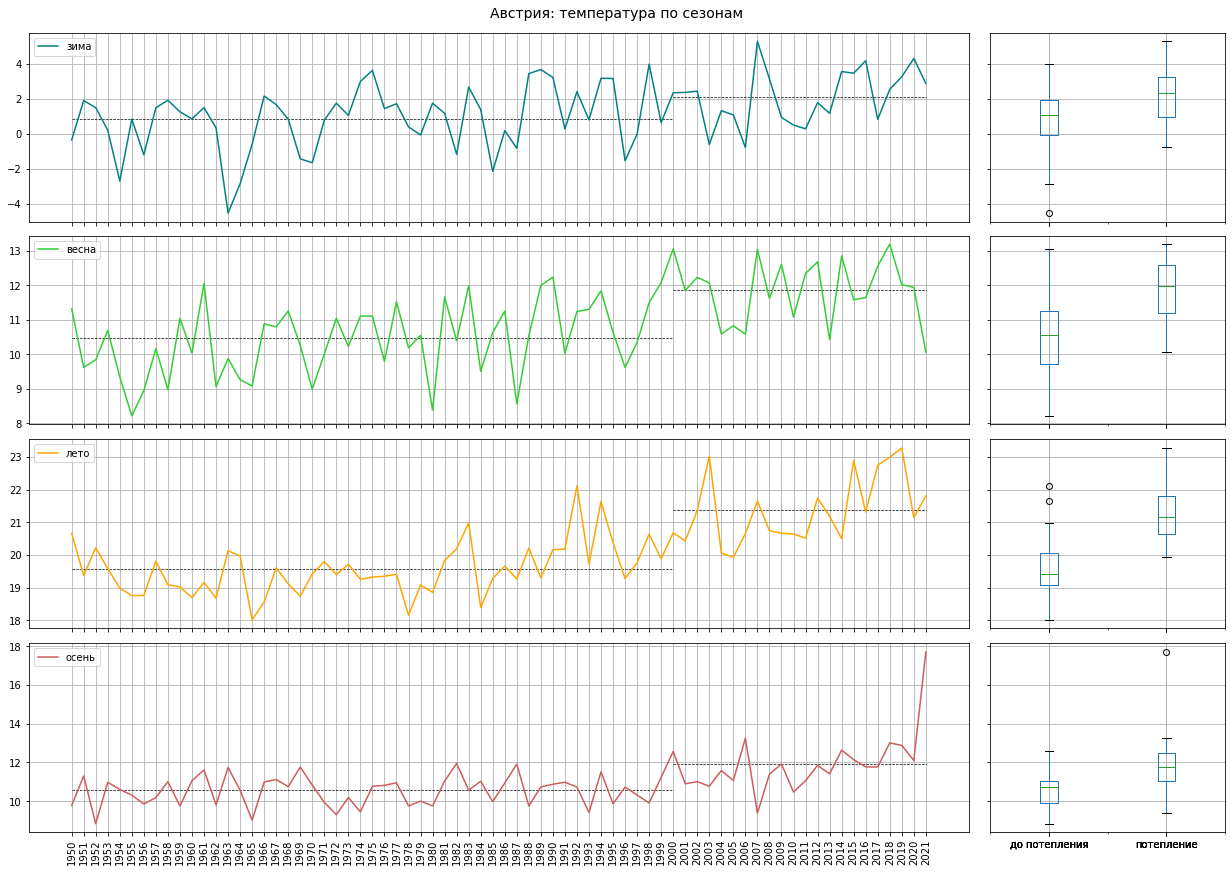

In [16]:
plot_seasons(pdfATemp, country='Австрия')

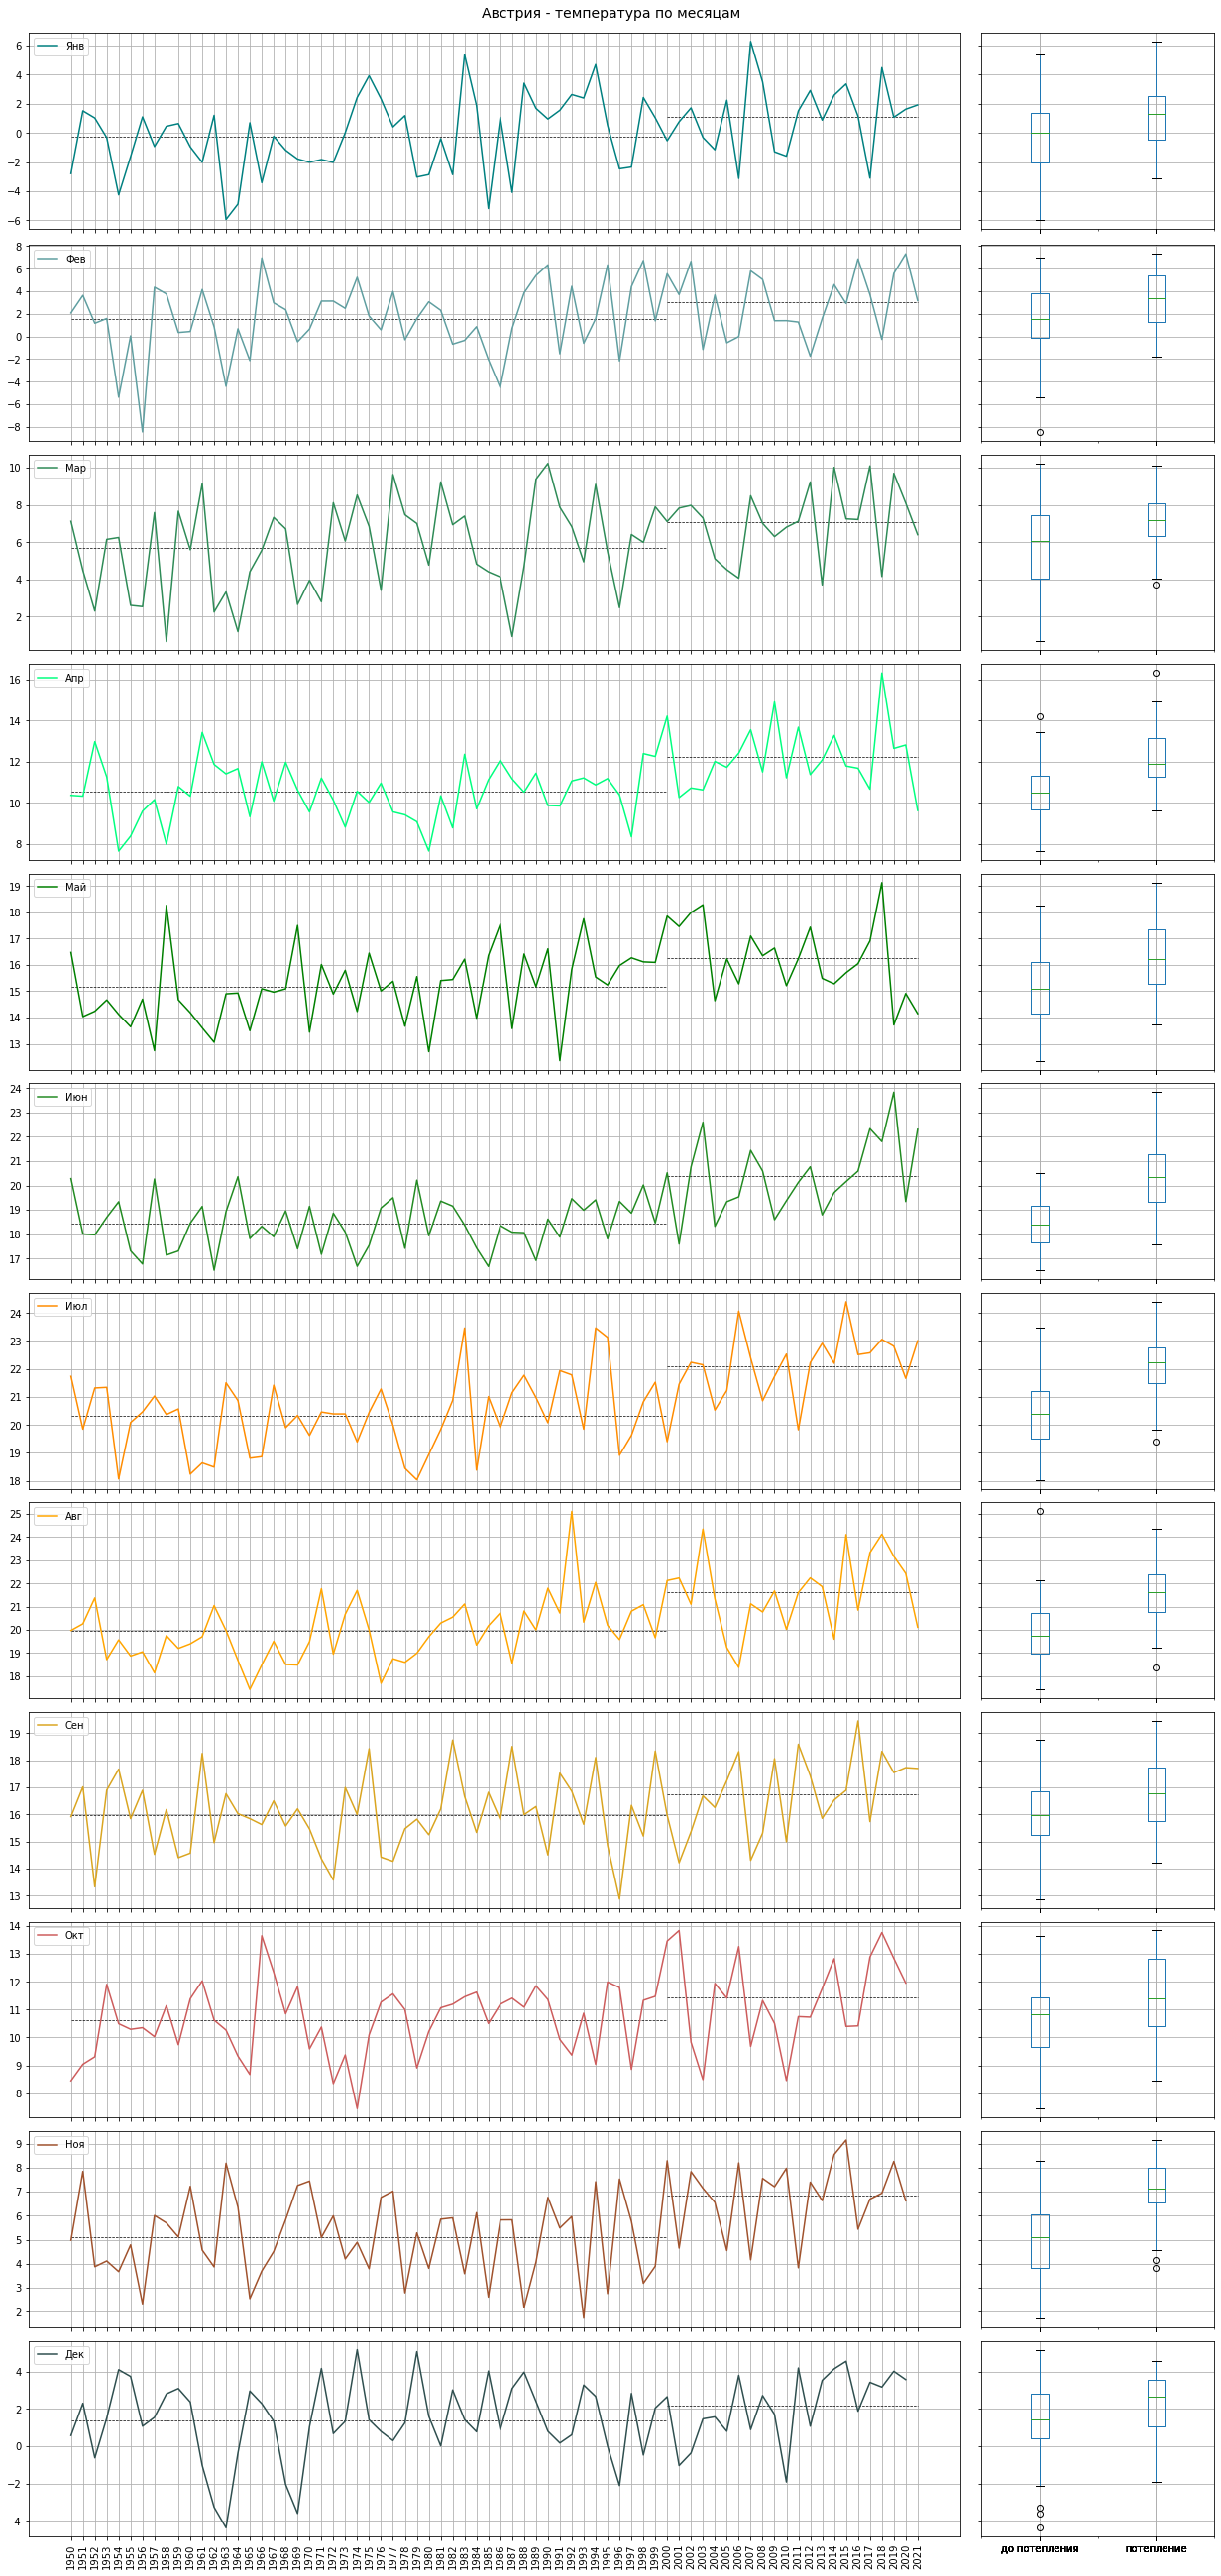

In [17]:
plot_months(pdfATemp, country='Австрия')

## Испания (MADRID-RETIRO, 230, файл TG_STAID000230.txt)

In [18]:
strSFile='TG_STAID000230.txt'

pdfS = read_csv(strSFile)
pdfS

,date,tempC,stat
0,1920-01-01,104,0
1,1920-01-02,68,0
2,1920-01-03,55,0
3,1920-01-04,46,0
4,1920-01-05,41,0
...,...,...,...
37159,2021-09-26,177,0
37160,2021-09-27,188,0
37161,2021-09-28,195,0
37162,2021-09-29,184,0


### Проверяем: статус <> 0 значит что данные недостоверные

In [19]:
pdfS[pdfS['stat']!=0]

,date,tempC,stat
516,1921-05-31,-9999,9
6159,1936-11-11,-9999,9
6160,1936-11-12,-9999,9
6161,1936-11-13,-9999,9
6162,1936-11-14,-9999,9
...,...,...,...
7048,1939-04-19,-9999,9
7049,1939-04-20,-9999,9
7050,1939-04-21,-9999,9
7059,1939-04-30,-9999,9


In [20]:
pdfS = pdfS[pdfS['date'].dt.year > 1949]
pdfS = pdfS.set_index('date')

pdfSTemp = pdfS.groupby(pd.Grouper(freq='MS'))['tempC'].mean() * 0.1
pdfSTemp = pd.DataFrame(pdfSTemp)
pdfSTemp

,tempC
date,
1950-01-01,5.422581
1950-02-01,7.810714
1950-03-01,10.754839
1950-04-01,12.736667
1950-05-01,15.629032
...,...
2021-05-01,17.951613
2021-06-01,22.226667
2021-07-01,25.670968


### Графики

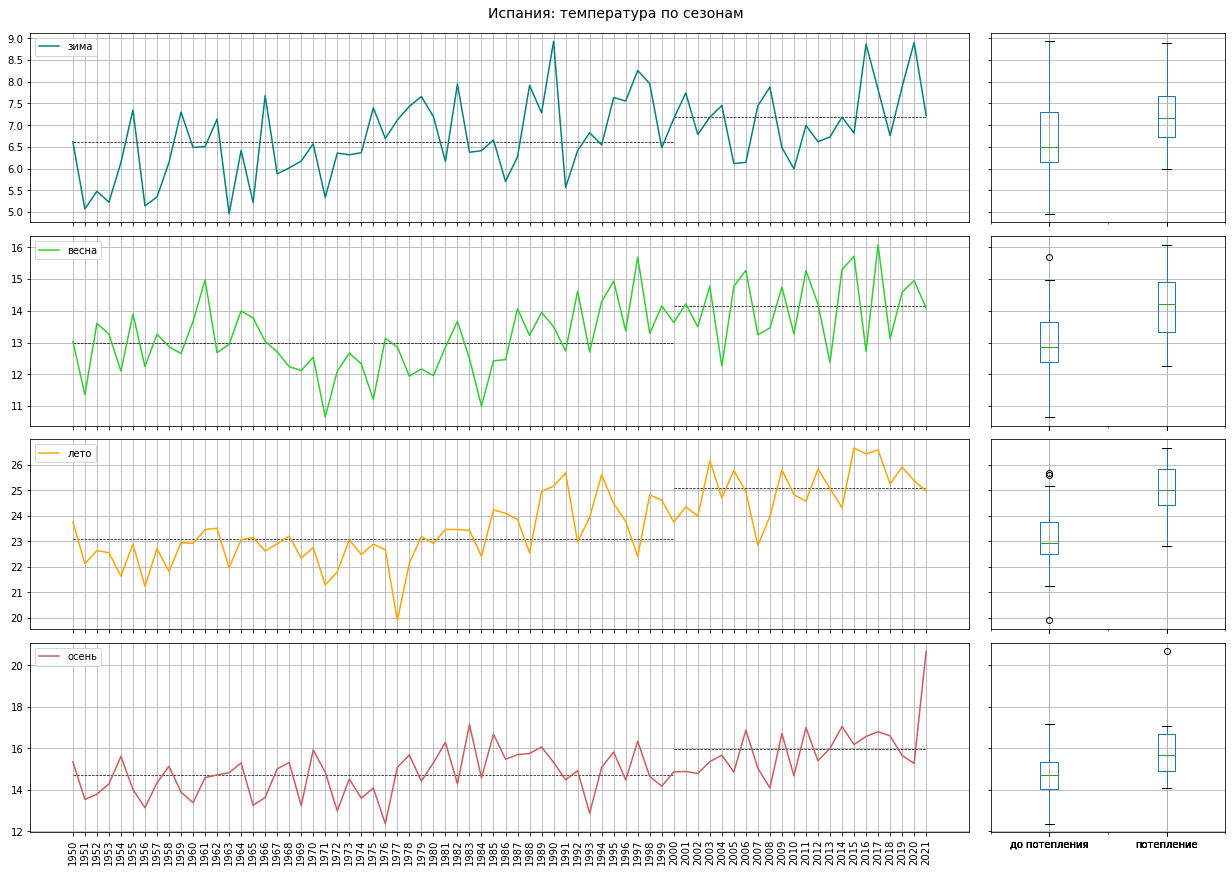

In [21]:
plot_seasons(pdfSTemp, country='Испания')

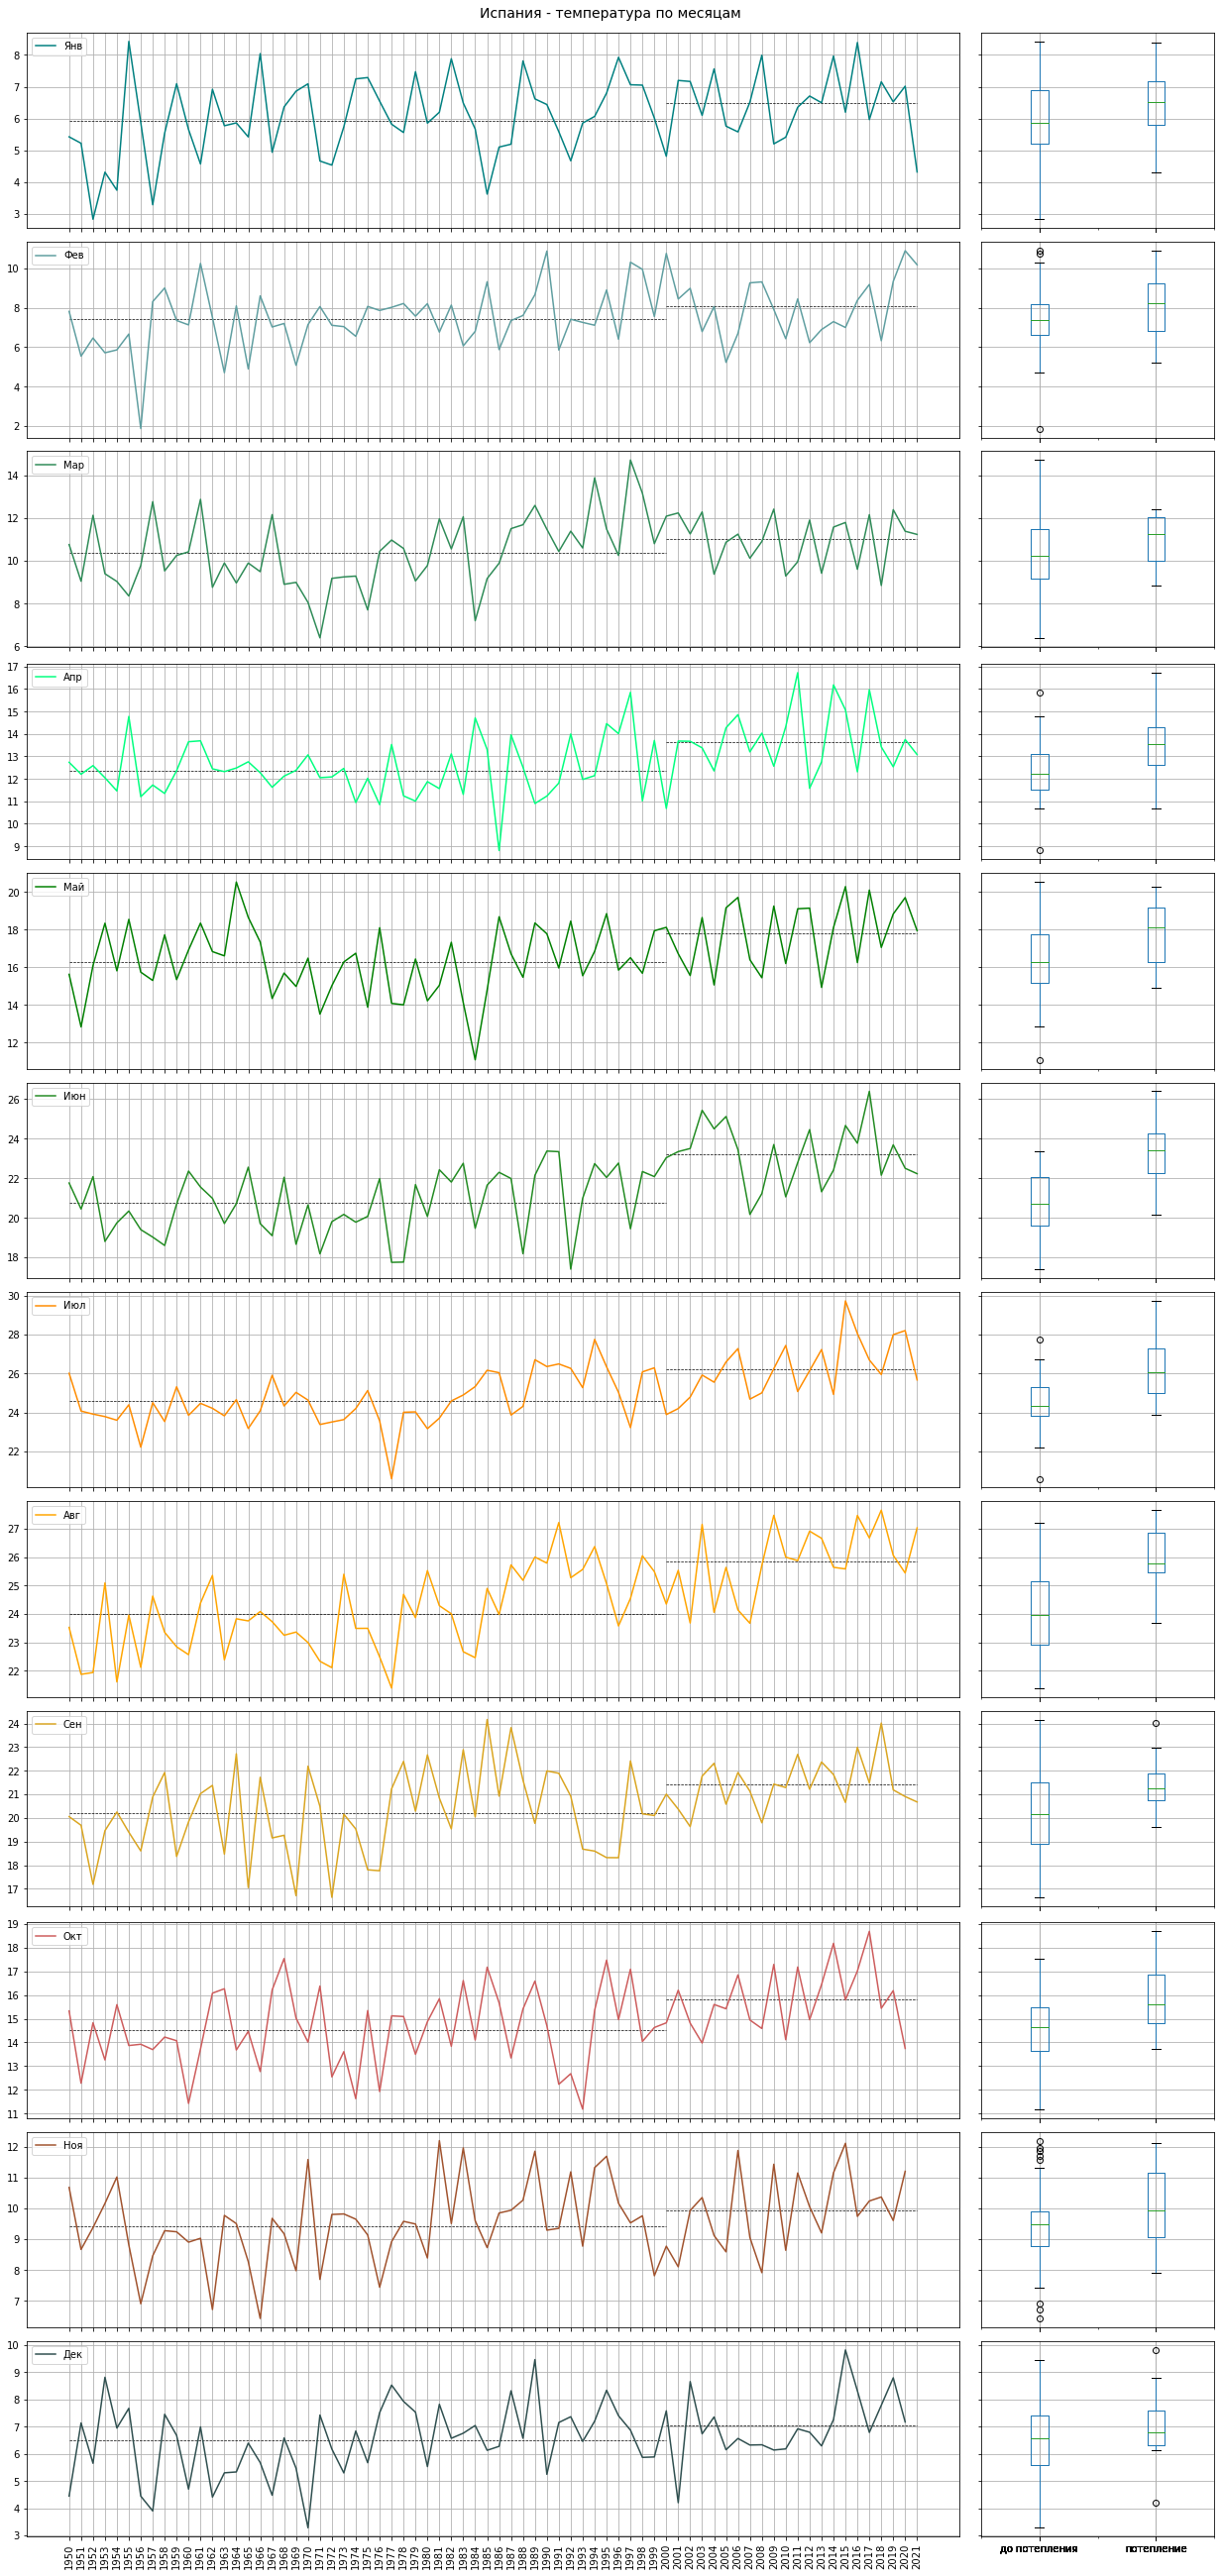

In [22]:
plot_months(pdfSTemp, country='Испания')